In [1]:
import cv2
import numpy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [61]:
def mouth_extractor(file_path:str, scale_factor=1.3, min_neighbors=5, mouth_size=(140, 70))->None:
    """
    Extract the mouth from the video save as npy file
    :param file_path:
    :return: npy file
    """

    if file_path.endswith('.mpg'):
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            raise Exception("Error: Could not open video.")
        frames=[]
        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            ret, frame = cap.read()
            if not ret:
                raise Exception("Error: Could not read frame.")
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Convert to grayscale
            faces = face_cascade.detectMultiScale(gray, scale_factor, min_neighbors)
            for (x, y, w, h) in faces:
                
                mouth_roi = frame[y + int(h / 2):y + h, x:x + w]
                mouth_roi = cv2.resize(mouth_roi, mouth_size)
                mouth_roi = cv2.cvtColor(mouth_roi, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                frames.append(mouth_roi)

        cap.release()
        mean = np.mean(frames)
        std = np.std(frames)
        frames = [(frame - mean) / std for frame in frames]
        frames_tensor = np.array(frames)
        # save as npy file
        np.save(file_path.split('.')[0] + '_mouth.npy', frames_tensor)
        return frames_tensor
        
        
    else:
        raise Exception("Error: File format not supported.")
        


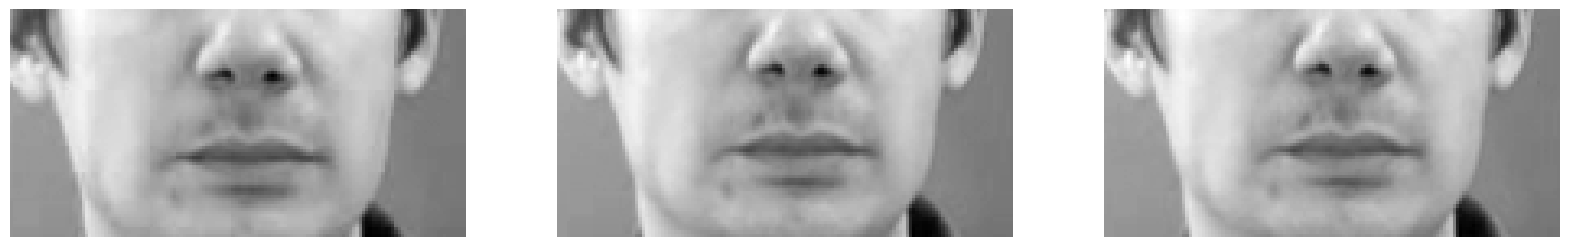

In [62]:
frames_tensor=mouth_extractor('../data/s1/bbbmzn.mpg')
# show the first 10 frames
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for i in range(3):
    ax[i].imshow(frames_tensor[i], cmap='gray')
    ax[i].axis('off') # no axes for this plot
plt.show()


[[-0.3514759  -1.07981543 -1.46132661 ... -1.01044976 -1.01044976
  -0.94108409]
 [-0.3514759  -1.07981543 -1.49600945 ... -1.01044976 -1.01044976
  -0.94108409]
 [-0.42084157 -1.18386393 -1.56537512 ... -0.97576692 -0.97576692
  -0.97576692]
 ...
 [-0.38615873 -0.42084157 -0.42084157 ... -1.18386393 -1.18386393
  -1.18386393]
 [-0.38615873 -0.42084157 -0.42084157 ... -1.18386393 -1.18386393
  -1.18386393]
 [-0.38615873 -0.4555244  -0.4555244  ... -1.21854677 -1.21854677
  -1.21854677]]


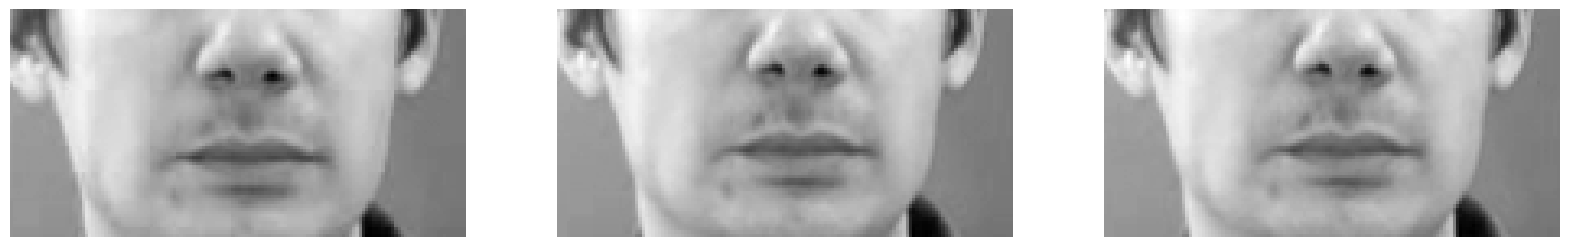

In [56]:
frames_tensor=mouth_extractor('../data/s1/bbbmzn.mpg')
# show the first 10 frames
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for i in range(3):
    ax[i].imshow(frames_tensor[i], cmap='gray')
    ax[i].axis('off') # no axes for this plot
plt.show()

In [60]:
np.load('_mouth.npy').shape

(75, 70, 140)

In [103]:
import logging
import os
import glob
from typing import List, Tuple
import numpy as np
def load_data(dir)->List[Tuple[np.ndarray,np.ndarray]]:
    data = []
    # 递归搜索该目录下的文件含有align的文件
    alignments = glob.glob(dir + '/**/*.align', recursive=True)
    alignments_dict={}
    for align in alignments:
        alignments_dict[align.split('/')[-1].split('.')[0]]=load_alignments(align)
    for root,dir,files in os.walk(dir):
        for file in files:
            if file.endswith('.npy'):
                video_frames = np.load(os.path.join(root,file))
                filename = file.split('.')[0]
                if filename in alignments_dict:
                    alignments = alignments_dict[filename]
                else:
                    logging.warning(f'No alignment found for {filename}')
                    alignments = ''
                data.append((video_frames,alignments))
    return data
def load_alignments(path:str)->np.array:
    with open (path,'r') as f:
        lines = f.readlines()
        tokens = ''
        for line in lines:
            line = line.split()
            if line[2] != 'sil': 
                tokens = tokens + ' ' + line[2]
        tokens_np=np.array([ord(c) for c in tokens])
        return tokens_np

In [104]:
data=load_data('/Users/zhenyili/research project/src/lipNet/data')
print(data)

[(array([[[-0.3514759 , -1.07981543, -1.46132661, ..., -1.01044976,
         -1.01044976, -0.94108409],
        [-0.3514759 , -1.07981543, -1.49600945, ..., -1.01044976,
         -1.01044976, -0.94108409],
        [-0.42084157, -1.18386393, -1.56537512, ..., -0.97576692,
         -0.97576692, -0.97576692],
        ...,
        [-0.38615873, -0.42084157, -0.42084157, ..., -1.18386393,
         -1.18386393, -1.18386393],
        [-0.38615873, -0.42084157, -0.42084157, ..., -1.18386393,
         -1.18386393, -1.18386393],
        [-0.38615873, -0.4555244 , -0.4555244 , ..., -1.21854677,
         -1.21854677, -1.21854677]],

       [[ 0.65432632,  1.0358375 ,  0.2381323 , ..., -0.97576692,
         -0.97576692, -0.97576692],
        [ 1.17456884,  1.34798301,  0.37686364, ..., -0.97576692,
         -0.97576692, -0.97576692],
        [ 1.45203152,  1.31330018,  0.3421808 , ..., -1.01044976,
         -1.01044976, -1.04513259],
        ...,
        [-0.38615873, -0.38615873, -0.38615873, ...,

In [115]:
def pretain(dir:str)->List:
    """
    find all the video and extra the mouth region 
    :param dir: 
    :return: 
    """
    video_list=glob.glob(dir+'/**/*.mpg',recursive=True)
    return video_list
    

In [116]:
video_list=pretain('/Users/zhenyili/research project/src/lipNet/data')


In [117]:
print(video_list)

['/Users/zhenyili/research project/src/lipNet/data/s1/prwq3s.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pbib8p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/lrae3s.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pgid6p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pbao8n.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/prbx3s.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/lbbk6p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/bgwu6n.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/sbig6p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pgby5s.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/bras8p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/sgiczp.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/lrwl7a.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/bbbz8n.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/bram3s.mpg', '/Users/z